In [1]:
import os, cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from collections import defaultdict, namedtuple
from tqdm import tqdm
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import xception, vgg19
from tensorflow.keras.applications import Xception, vgg19
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, Activation, Dense, Dropout 
from tensorflow.keras.layers import BatchNormalization, Conv2D, Embedding, MaxPool2D, SeparableConv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import Xception,resnet 
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import *
from keras.optimizers import Adam, SGD, Adamax
from tensorflow.keras.optimizers import Adam
from keras.layers import Concatenate
from keras.utils.np_utils import to_categorical 

from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy



# gpu 사용가능 확인

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1544140496727652215
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6298796032
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2444068934947999573
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:08:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


# 필요한 만큼 메모리를 런타임에 할당하는 방법

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)     


1 Physical GPUs, 1 Logical GPUs


# warnings hide

In [4]:
import warnings
# 경고 메시지를 무시하고 숨기거나
warnings.filterwarnings(action='ignore')

In [5]:
SEED = 42
seed = 42
EPOCHS = 100
epochs = 100
BATCH_SIZE = 32
batch_size = 32
IMG_HEIGHT = 224
img_height = 224
IMG_WIDTH = 224
img_width = 224
num_classes = 8
patience = 5

In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [7]:
seed_everything(seed)

In [8]:
full_df = pd.read_csv('full_df(agumentation).csv', index_col= 0)

In [9]:
full_df['labels'] = full_df['labels'].map({'N' : 0, 'D' : 1, 'G' : 2, 'C' : 3,  'A' : 4, 'H' : 5, 'M' : 6, 'O' : 7})

In [10]:
full_df['labels'].value_counts()

0    2873
4    2128
7    2124
3    2051
1    2008
2    1988
6    1856
5    1280
Name: labels, dtype: int64

In [11]:
full_df['labels'].value_counts().sum()

16308

In [12]:
df = full_df[:13000]

In [13]:
df

,filename,labels
10086,preprocessed_images(divide)/M/M_270_1621_right...,6
1176,preprocessed_images(divide)/A/A_blur_1877_left...,4
13744,preprocessed_images(divide)/N/4057_left.jpg,0
12015,preprocessed_images(divide)/N/2564_left.jpg,0
8754,preprocessed_images(divide)/H/H_90_fliplr_4214...,5
...,...,...
5085,preprocessed_images(divide)/D/4400_right.jpg,1
9428,preprocessed_images(divide)/H/H_flipud_723_lef...,5
8657,preprocessed_images(divide)/H/H_90_686_left.jpg,5
9667,preprocessed_images(divide)/M/401_left.jpg,6


# 데이터

In [14]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['filename']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
#   df = pd.get_dummies(df['labels'])
    df = to_categorical(df['labels'], num_classes = 8)
    return imgs, df

In [15]:
# train data, test data 분리
train_df, test_df = train_test_split(df,
                                     test_size=0.30, 
                                     random_state=42,
                                     stratify=df['labels']
                                    )

train_df, val_df = train_test_split(train_df,
                                    test_size=0.20,
                                    random_state=42,
#                                    stratify=train_df['labels']
                                   )

In [16]:
train_df.shape, test_df.shape, val_df.shape

((7280, 2), (3900, 2), (1820, 2))

In [17]:
train_imgs, train_labels = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_labels = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_labels = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

100%|██████████| 3900/3900 [00:14<00:00, 272.63it/s]


In [23]:
train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0


In [24]:
'''
train_imgs = preprocess_input(train_imgs)
val_imgs = preprocess_input(val_imgs)
test_imgs = preprocess_input(test_imgs)
'''

'\ntrain_imgs = preprocess_input(train_imgs)\nval_imgs = preprocess_input(val_imgs)\ntest_imgs = preprocess_input(test_imgs)\n'

In [25]:
len(train_imgs), len(val_imgs), len(test_imgs)

(7280, 1820, 3900)

In [26]:
train_imgs.shape, val_imgs.shape, test_imgs.shape

((7280, 224, 224, 3), (1820, 224, 224, 3), (3900, 224, 224, 3))

In [27]:
train_labels.shape, val_labels.shape, test_labels.shape

((7280, 8), (1820, 8), (3900, 8))

# Model

In [35]:
del model

In [36]:
BinaryAccuracy = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]


In [37]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet =  tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classifier_activation='softmax'
)

    
  
    
    
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(8, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.00003)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=[BinaryAccuracy])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 20,028,488
Trainable params: 20,028,488
Non-trainable params: 0
_________________________________________________________________


In [38]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
227/227 [==============================] - 88s 362ms/step - loss: 0.3134 - accuracy: 0.8883 - precision: 0.6936 - recall: 0.1912 - auc: 0.7958 - val_loss: 0.2724 - val_accuracy: 0.9002 - val_precision: 0.8509 - val_recall: 0.2445 - val_auc: 0.8628 - lr: 3.0000e-05
Epoch 2/100
227/227 [==============================] - 86s 378ms/step - loss: 0.2562 - accuracy: 0.9043 - precision: 0.7699 - recall: 0.3342 - auc: 0.8885 - val_loss: 0.2370 - val_accuracy: 0.9100 - val_precision: 0.7736 - val_recall: 0.3962 - val_auc: 0.9106 - lr: 3.0000e-05
Epoch 3/100
227/227 [==============================] - 87s 379ms/step - loss: 0.2334 - accuracy: 0.9128 - precision: 0.7873 - recall: 0.4139 - auc: 0.9141 - val_loss: 0.2286 - val_accuracy: 0.9114 - val_precision: 0.7912 - val_recall: 0.3956 - val_auc: 0.9209 - lr: 3.0000e-05
Epoch 4/100
227/227 [==============================] - 87s 380ms/step - loss: 0.2172 - accuracy: 0.9191 - precision: 0.7968 - recall: 0.4734 - auc: 0.9299 - val_loss: 0.

Epoch 30/100
227/227 [==============================] - 87s 380ms/step - loss: 0.0390 - accuracy: 0.9998 - precision: 0.9995 - recall: 0.9989 - auc: 1.0000 - val_loss: 0.1941 - val_accuracy: 0.9442 - val_precision: 0.8068 - val_recall: 0.7275 - val_auc: 0.9541 - lr: 3.0000e-06
Epoch 31/100
227/227 [==============================] - 87s 380ms/step - loss: 0.0389 - accuracy: 0.9997 - precision: 0.9993 - recall: 0.9986 - auc: 1.0000 - val_loss: 0.1961 - val_accuracy: 0.9442 - val_precision: 0.8103 - val_recall: 0.7231 - val_auc: 0.9534 - lr: 3.0000e-06
Epoch 32/100
227/227 [==============================] - 87s 383ms/step - loss: 0.0384 - accuracy: 0.9998 - precision: 0.9996 - recall: 0.9989 - auc: 1.0000 - val_loss: 0.1948 - val_accuracy: 0.9439 - val_precision: 0.8052 - val_recall: 0.7269 - val_auc: 0.9537 - lr: 3.0000e-06
Epoch 33/100
228/227 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9998 - precision: 0.9996 - recall: 0.9988 - auc: 1.0000Restoring model we

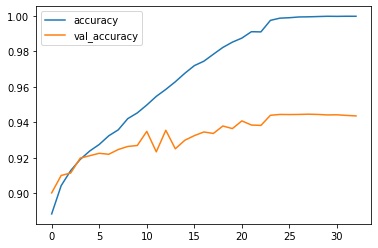

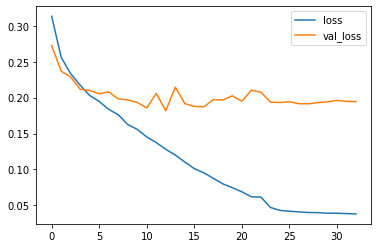

In [39]:
history = model.fit(generator.flow(train_imgs, 
                                   train_labels,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_labels))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [40]:
model.save('VGG19.h5')

In [28]:
load_model = tf.keras.models.load_model('VGG19.h5')

In [29]:
load_model.evaluate(test_imgs, test_labels)

122/122 [==============================] - 21s 123ms/step - loss: 0.7079 - accuracy: 0.7815 - precision: 0.1259 - recall: 0.1259 - auc: 0.4773


[0.7078897953033447,
 0.7814743518829346,
 0.12589743733406067,
 0.12589743733406067,
 0.4773359000682831]

In [30]:
for iii in range(0, 10):
    print(load_model.predict(test_imgs[iii:iii+1]))
    print(test_labels[iii,:])
    print()

1/1 [==============================] - 1s 777ms/step
[[0.0027183  0.00280773 0.06650421 0.7954362  0.00518775 0.01547012
  0.00984466 0.07403457]]
[1. 0. 0. 0. 0. 0. 0. 0.]

1/1 [==============================] - 0s 15ms/step
[[0.00271477 0.00281457 0.06623708 0.7962229  0.00515922 0.01527098
  0.0098774  0.074098  ]]
[0. 0. 0. 0. 0. 1. 0. 0.]

1/1 [==============================] - 0s 15ms/step
[[0.00271809 0.00280472 0.06652908 0.7960619  0.0051769  0.01541992
  0.00986658 0.07387129]]
[1. 0. 0. 0. 0. 0. 0. 0.]

1/1 [==============================] - 0s 15ms/step
[[0.00272556 0.00281421 0.0663846  0.79615414 0.00517001 0.01535091
  0.00987875 0.07374854]]
[0. 0. 0. 1. 0. 0. 0. 0.]

1/1 [==============================] - 0s 16ms/step
[[0.00273144 0.00283068 0.06579737 0.79790956 0.00523987 0.0156668
  0.00991714 0.07273643]]
[0. 1. 0. 0. 0. 0. 0. 0.]

1/1 [==============================] - 0s 15ms/step
[[0.00273011 0.00279702 0.06722552 0.79464036 0.00517879 0.01545035
  0.00987408 0.